# Molecular Gas Main Sequence (MGMS) Plots for NGVS-VERTICO Sample

Isaac Cheng - December 2021

Based on the [MGMS notebook](../../galaxies/MGMS/MGMS.ipynb).

Remember: everything must be done at VERTICO Nyquist resolution!


In [1]:
MGMS_PATH = "/arc/home/IsaacCheng/coop_f2021/galaxies/MGMS/"  # change to current path
%cd "$MGMS_PATH"

from multiprocessing import Pool
import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS

from ltsfit.lts_linefit import lts_linefit  # Capellari's least-trimmed-squares fitting
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
import radial_profile_utils as rpu
# 
GALDIST = 16.5 * u.Mpc  # distance to Virgo cluster centre

/arc/home/IsaacCheng/coop_f2021/galaxies/MGMS


Following are arrays containing information related to the NGVS-VERTICO galaxies.


In [2]:
# ----------------------------------------------------------------------------------------
GALAXIES = np.array(
    [
        "IC3392",
        # "NGC4189",  # ignored flag map, but bad results
        "NGC4192",
        "NGC4216",  # has unflagged foreground star
        "NGC4222",
        "NGC4254",
        "NGC4294",
        "NGC4298",
        "NGC4299",
        "NGC4302",
        "NGC4321",
        "NGC4330",
        "NGC4351",
        "NGC4380",
        "NGC4383",
        "NGC4388",
        "NGC4396",
        "NGC4402",
        "NGC4405",
        "NGC4419",
        "NGC4424",
        "NGC4450",
        "NGC4501",
        "NGC4522",
        "NGC4532",
        "NGC4535",
        "NGC4548",
        "NGC4567",
        "NGC4568",
        "NGC4569",
        "NGC4579",
        "NGC4580",
        # "NGC4606",  # flag map too intrusive
        "NGC4607",
        "NGC4651",
        "NGC4654",
        "NGC4689",
        "NGC4694",
    ]
)
INCLINATIONS = np.array(
    [
        68,
        # 42,  # ignored flag map, but bad results
        83,
        90,  # has unflagged foreground star
        90,
        39,
        74,
        52,
        14,
        90,
        32,
        90,
        48,
        61,
        56,
        83,
        83,
        80,
        46,
        74,
        61,
        51,
        65,
        82,
        64,
        48,
        37,
        49,
        70,
        69,
        40,
        46,
        # 69,  # flag map too intrusive
        90,
        53,
        61,
        38,
        62,
    ]
)  # degrees
POSITION_ANGLES = np.array(
    [
        219,
        # 70,  # ignored flag map, but bad results
        333,
        20,  # has unflagged foreground star
        238,
        243,
        151,
        132,
        128,
        356,
        280,
        238,
        251,
        158,
        17,
        271,
        304,
        270,
        18,
        131,
        274,
        170,
        320,
        35,
        159,
        12,
        318,
        251,
        211,
        203,
        273,
        337,
        # 38,  # flag map too intrusive
        2,
        75,
        300,
        341,
        323,
    ]
)  # degrees
# ----------------------------------------------------------------------------------------
# N.B. "high inclination" means inclination >= 80 degrees
HIGH_I_GALAXIES = np.array(
    [
        "NGC4192",
        "NGC4216",
        "NGC4222",
        "NGC4302",
        "NGC4330",
        "NGC4388",
        "NGC4396",
        "NGC4402",
        "NGC4522",
        "NGC4607",
    ]
)
HIGH_I_INCLINATIONS = np.array([83, 90, 90, 90, 90, 83, 83, 80, 82, 90,])  # degrees
HIGH_I_POSITION_ANGLES = np.array(
    [333, 20, 238, 356, 238, 271, 304, 270, 35, 2]
)  # degrees
# ----------------------------------------------------------------------------------------
HIGH_I_HEIGHTS_ARCSEC = np.array(
    [80, 60, 25, 55, 38, 65, 43, 45, 40, 70,]
)  # arcsec, for radial profiles
# ----------------------------------------------------------------------------------------
VCC_GALAXIES = np.array(
    [
        1126,  # IC3392
        # 89,  # NGC4189, ignored flag map, but bad results
        92,  # NGC4192
        167,  # NGC4216, has unflagged foreground star
        187,  # NGC4222
        307,  # NGC4254
        465,  # NGC4294
        483,  # NGC4298
        491,  # NGC4299
        497,  # NGC4302
        596,  # NGC4321
        630,  # NGC4330
        692,  # NGC4351
        792,  # NGC4380
        801,  # NGC4383
        836,  # NGC4388
        865,  # NGC4396
        873,  # NGC4402
        874,  # NGC4405
        958,  # NGC4419
        979,  # NGC4424
        1110,  # NGC4450
        1401,  # NGC4501
        1516,  # NGC4522
        1554,  # NGC4532
        1555,  # NGC4535
        1615,  # NGC4548
        1673,  # NGC4567
        1676,  # NGC4568
        1690,  # NGC4569
        1727,  # NGC4579
        1730,  # NGC4580
        # 1859,  # NGC4606, flag map too intrusive
        1868,  # NGC4607
        -100,  # NGC4651 (EVCC number is 1102, cannot use EVCC number)
        1987,  # NGC4654
        2058,  # NGC4689
        2066,  # NGC4694
    ]
)

Below are 2 functions to calculate the MGMS quantities (i.e., the log(gas density) and
log(stellar mass density)) as well as the least-trimmed-squares (LTS) line of best fit to
these MGMS data.


In [3]:
ALPHA_CO = 4.35  # M_sun/pc^2 per (K km/s)
R_21 = 0.8  # dimensionless. CO(2-1)/CO(1-0) ratio
I_THRESHOLD = 80  # degrees


def get_mgms_quantities(
    galaxy, alpha_co=ALPHA_CO, r_21=R_21, inclination=None, i_threshold=I_THRESHOLD
):
    """
    Calculates the resolved log10(molecular gas density) and log10(stellar mass density)
    data of a galaxy.
    
    Called by do_mgms_lts().
    """
    #
    # Load stellar mass density data
    #
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
    galaxy_infile = (
        galpath + f"{galaxy}_regBin_extinctionCorr_nyquist_ugiz_Sigma-star_noNorm_i_corr.pkl"
    )
    with open(galaxy_infile, "rb") as f:
        file = dill.load(f)
        M_density = file["stellar_mass_density"]
        M_density_err = file["stellar_mass_density_err"]
        # print(f"{galaxy}'s bin_dimensions:", file["bin_dimensions"])
        file = None  # free memory
    #
    # Load molecular gas data
    #
    if (
        galaxy == "NGC4321"
    ):  # no 9 arcsec data since native is 10 arcsec. Use 15 arcsec data instead
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/nyquistPix/15arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_15as_np_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/nyquistPix/15arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_15as_np_round_mom0_unc.fits"
    else:
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_np_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"
    Ico_data = fits.getdata(Ico_path)
    Ico_unc = fits.getdata(Ico_unc_path)  # uncertainty
    #
    # Convert to gas density (M_sun/pc^2)
    #
    gas_density_i_uncorr = alpha_co / r_21 * Ico_data
    gas_density_unc_i_uncorr = alpha_co / r_21 * Ico_unc
    #
    # Correct for inclination
    #
    if inclination is None:
        inclination = INCLINATIONS[galaxy == GALAXIES]
        if inclination.size != 1:
            raise ValueError(
                f"{galaxy}'s inclination should only have 1 element. inclination = {gal_inclination}"
            )
        inclination = inclination[0]
    gas_density = rpu.correct_for_i(
        gas_density_i_uncorr,
        inclination,
        i_threshold=i_threshold,
        i_replacement=i_threshold,
    )
    gas_density_unc = rpu.correct_for_i(
        gas_density_unc_i_uncorr,
        inclination,
        i_threshold=i_threshold,
        i_replacement=i_threshold,
    )
    #
    # Take log10 of quantities
    #
    log_M_density = np.log10(M_density)
    log_M_density_err = M_density_err / (np.log(10) * M_density)
    log_gas_density = np.log10(gas_density)
    log_gas_density_err = gas_density_unc / (np.log(10) * gas_density)
    #
    # Mask to remove bad pixels (required for LTS fitting)
    #
    mgms_isgood = (
        np.isfinite(log_gas_density)
        & np.isfinite(log_gas_density_err)
        & np.isfinite(log_M_density)
        & np.isfinite(log_M_density_err)
    )
    return (
        log_M_density,
        log_M_density_err,
        log_gas_density,
        log_gas_density_err,
        mgms_isgood,
    )


def do_mgms_lts(galaxy, clip=2.6, pivot_func=np.median, plot=True, frac=None, **kwargs):
    """
    Calculates the line of best fit to a galaxy's resolved MGMS using LTS
    """
    (
        log_M_density,
        log_M_density_err,
        log_gas_density,
        log_gas_density_err,
        mgms_isgood,
    ) = get_mgms_quantities(galaxy, **kwargs)
    pivot = pivot_func(log_M_density[mgms_isgood])
    lts_popt = lts_linefit(
        log_M_density[mgms_isgood],
        log_gas_density[mgms_isgood],
        log_M_density_err[mgms_isgood],
        log_gas_density_err[mgms_isgood],
        clip=clip,
        epsy=True,
        corr=True,
        frac=frac,
        pivot=pivot,
        plot=plot,
        text=True,
    )
    lts_int, lts_slope = lts_popt.ab
    lts_int_err, lts_slope_err = lts_popt.ab_err
    lts_rms = lts_popt.rms
    lts_yint = lts_int - lts_slope * pivot
    lts_yint_err = np.sqrt(lts_int_err ** 2 + (lts_slope_err * pivot) ** 2)
    print(
        f"{galaxy}'s LTS line: y = ({lts_slope} +/- {lts_slope_err}) * x + ({lts_yint} +/- {lts_yint_err})"
    )
    return (
        (
            log_M_density,
            log_M_density_err,
            log_gas_density,
            log_gas_density_err,
            mgms_isgood,
        ),
        (
            pivot,
            lts_slope,
            lts_slope_err,
            lts_int,
            lts_int_err,
            lts_rms,
            lts_yint,
            lts_yint_err,
        ),
    )



# Resolved MGMS (rMGMS) for NGC 4380

We will auto-generate rMGMS plots for all galaxies after. For now, just make a nice plot
of NGC 4380's rMGMS

/tmp/ipykernel_6990/3365738129.py:68: RuntimeWarning: divide by zero encountered in log10
  log_gas_density = np.log10(gas_density)
/tmp/ipykernel_6990/3365738129.py:68: RuntimeWarning: invalid value encountered in log10
  log_gas_density = np.log10(gas_density)


sig_int:     0.0000      7.9729
Computing sig_int
sig_int:     0.0000      7.9729
sig_int:     0.3034     -0.7185
sig_int:     0.2784     -0.6665
sig_int:     0.1392      0.2494
sig_int:     0.1771     -0.2093
sig_int:     0.1598     -0.0397
sig_int:     0.1563      0.0010
sig_int:     0.1564     -0.0000
Computing sig_int error
sig_int:     0.1564      0.0468
sig_int:     0.3034     -0.6717
sig_int:     0.1660     -0.0590
sig_int:     0.1606     -0.0021
sig_int:     0.1604     -0.0001
sig_int:     0.1603      0.0008
Repeat at best fitting solution
sig_int:     0.1564     -0.0000
################# Values and formal errors ################
 intercept:  0.4247 +/- 0.0054
     slope:  0.539 +/- 0.016
   scatter:  0.1564 +/- 0.0041
Observed rms scatter: 0.16
y = a + b*(x - pivot) with pivot = 1.616
Spearman r=0.71 and p=4.3e-155
Pearson r=0.6 and p=1.1e-99
##########################################################
seconds 15.16
NGC4380's LTS line: y = (0.539282721013507 +/- 0.01573426810971

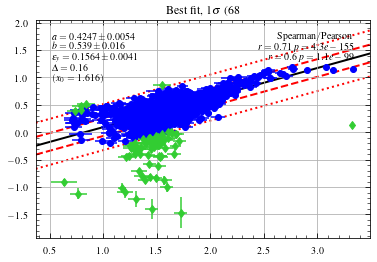

In [4]:
# Set these values
GALAXY_TO_PLOT = "NGC4380"
gal_clip = 2.6
gal_frac = None  # 1 means no outlier rejection
#
gal_inclination = INCLINATIONS[GALAXY_TO_PLOT == GALAXIES]
if gal_inclination.size != 1:
    raise ValueError(
        f"gal_inclination should only have 1 element. gal_inclination = {gal_inclination}"
    )
gal_inclination = gal_inclination[0]
#
(
    (gal_sigstar, gal_sigstar_err, gal_sigmol, gal_sigmol_err, gal_mgms_isgood),
    (
        gal_pivot,
        gal_slope,
        gal_slope_err,
        gal_int,
        gal_int_err,
        gal_rms,
        gal_yint,
        gal_yint_err,
    ),
) = do_mgms_lts(
    GALAXY_TO_PLOT, clip=gal_clip, pivot_func=np.median, inclination=gal_inclination, frac=gal_frac
)

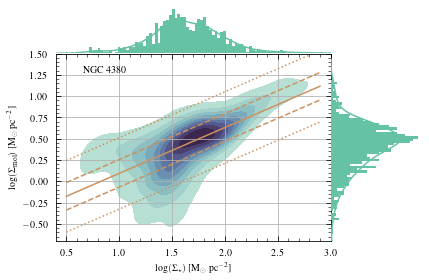

In [5]:
fig, ax, ax_r, ax_t = pu.joint_contour_plot(
    gal_sigstar[gal_mgms_isgood],
    gal_sigmol[gal_mgms_isgood],
    plot_lts=True,
    lts_slope=gal_slope,
    lts_int=gal_int,
    lts_pivot=gal_pivot,
    lts_rms=gal_rms,
    lts_clip=gal_clip,
    lts_xlim=(0.5, 2.9),
    fig_xlim=(0.4, 3.0),
    fig_ylim=(-0.7, 1.5),
    fig_xlabel=r"$\rm \log(\Sigma_\star)$ [$\rm M_\odot\; pc^{-2}$]",
    fig_ylabel=r"$\rm \log(\Sigma_{mol})$ [$\rm M_\odot\; pc^{-2}$]",
    plot_scatter=False,
    plt_show=False,
)
#
# Add galaxy name on plot
#
high_i_str = "*" if gal_inclination >= I_THRESHOLD else ""
ax.text(
    0.1,
    0.9,
    re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
    c="k",
    ha="left",
    transform=ax.transAxes,
)
# fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_MGMS_clip{gal_clip}_noNorm_i_corr.pdf")
plt.show()

Determine the spatial regions above/below the MGMS for NGC 4380


/tmp/ipykernel_6990/952623631.py:3: RuntimeWarning: divide by zero encountered in log10
  gas_fraction = np.log10((10 ** gal_sigmol) / (10 ** gal_sigstar))


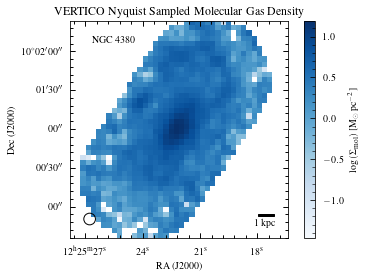

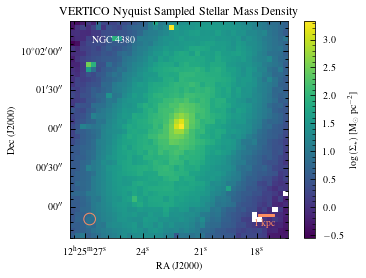

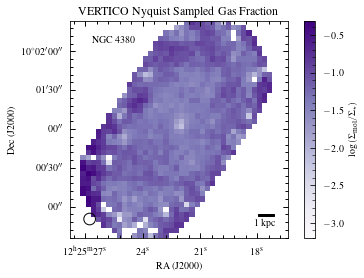

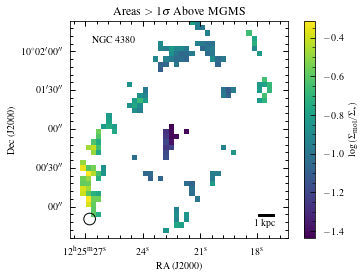

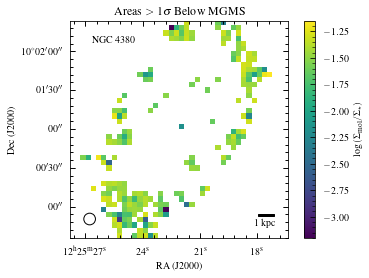

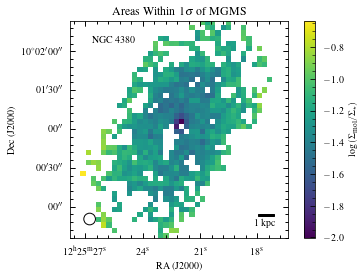

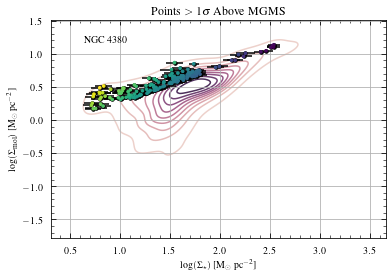

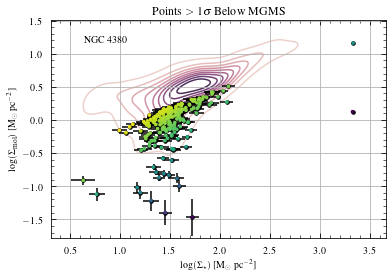

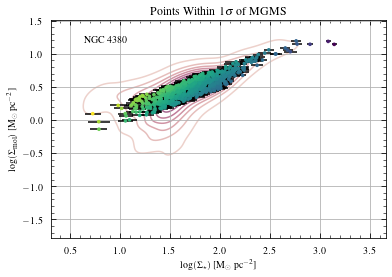

In [6]:
is_above_mgms = gal_sigmol > (gal_int + gal_slope * (gal_sigstar - gal_pivot) + gal_rms)  # above 1 sigma
is_below_mgms = gal_sigmol < (gal_int + gal_slope * (gal_sigstar - gal_pivot) - gal_rms)  # below 1 sigma
gas_fraction = np.log10((10 ** gal_sigmol) / (10 ** gal_sigstar))
gas_fraction_above_mgms = np.copy(gas_fraction)
gas_fraction_above_mgms[(~is_above_mgms) | (~gal_mgms_isgood)] = np.nan
gas_fraction_below_mgms = np.copy(gas_fraction)
gas_fraction_below_mgms[(~is_below_mgms) | (~gal_mgms_isgood)] = np.nan
gas_fraction_on_mgms = np.copy(gas_fraction)
gas_fraction_on_mgms[(is_above_mgms) | (is_below_mgms) | (~gal_mgms_isgood)] = np.nan
# 
# Plots
# 
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # ignore astropy warnings
    gal_co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_Kkms-1.fits"
    co_header = fits.getheader(gal_co_path)
    co_wcs = WCS(co_header)
    high_i_str = "*" if gal_inclination >= I_THRESHOLD else ""
    # Gas density at Nyquist resolution
    fig, ax = plt.subplots(subplot_kw={"projection": co_wcs})
    img = ax.imshow(gal_sigmol, cmap="Blues", vmin=None, vmax=None)
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label(r"$\rm \log\left(\Sigma_{mol}\right)$ [$\rm M_\odot\; pc^{-2}$]")
    pu.add_scalebar(ax, co_wcs, GALDIST)
    pu.add_scalebeam(ax, co_header)
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.grid(False)
    ax.set_aspect("equal")
    ax.set_title(r"VERTICO Nyquist Sampled Molecular Gas Density")
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_nyquist_gas_density.pdf")
    plt.show()
    # Stellar mass density at Nyquist resolution
    fig, ax = plt.subplots(subplot_kw={"projection": co_wcs})
    img = ax.imshow(gal_sigstar, cmap="viridis", vmin=None, vmax=None)
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label(r"$\rm \log\left(\Sigma_{\star}\right)$ [$\rm M_\odot\; pc^{-2}$]")
    pu.add_scalebar(ax, co_wcs, GALDIST, color="C1")
    pu.add_scalebeam(ax, co_header, ec="C1")
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.grid(False)
    ax.set_aspect("equal")
    ax.set_title(r"VERTICO Nyquist Sampled Stellar Mass Density")
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="w",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_nyquist_M_density.pdf")
    plt.show()
    # Gas fraction at Nyquist resolution
    fig, ax = plt.subplots(subplot_kw={"projection": co_wcs})
    img = ax.imshow(gas_fraction, cmap="Purples", vmin=None, vmax=None)
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$")
    pu.add_scalebar(ax, co_wcs, GALDIST)
    pu.add_scalebeam(ax, co_header)
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.grid(False)
    ax.set_aspect("equal")
    ax.set_title(r"VERTICO Nyquist Sampled Gas Fraction")
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_nyquist_gas_fraction.pdf")
    plt.show()
    # Regions > 1 sigma above MGMS (map)
    fig, ax = plt.subplots(subplot_kw={"projection": co_wcs})
    img = ax.imshow(gas_fraction_above_mgms, cmap="viridis", vmin=None, vmax=None)
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$")
    pu.add_scalebar(ax, co_wcs, GALDIST)
    pu.add_scalebeam(ax, co_header)
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.grid(False)
    ax.set_aspect("equal")
    ax.set_title(r"Areas $> 1 \sigma$ Above MGMS")
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_regions_aboveMGMS.pdf")
    plt.show()
    # Regions > 1 sigma below MGMS (map)
    fig, ax = plt.subplots(subplot_kw={"projection": co_wcs})
    img = ax.imshow(gas_fraction_below_mgms, cmap="viridis", vmin=None, vmax=None)
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$")
    pu.add_scalebar(ax, co_wcs, GALDIST)
    pu.add_scalebeam(ax, co_header)
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.grid(False)
    ax.set_aspect("equal")
    ax.set_title(r"Areas $> 1 \sigma$ Below MGMS")
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_regions_belowMGMS.pdf")
    plt.show()
    # Regions within 1 sigma of MGMS (map)
    fig, ax = plt.subplots(subplot_kw={"projection": co_wcs})
    img = ax.imshow(gas_fraction_on_mgms, cmap="viridis", vmin=None, vmax=None)
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$")
    pu.add_scalebar(ax, co_wcs, GALDIST)
    pu.add_scalebeam(ax, co_header)
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.grid(False)
    ax.set_aspect("equal")
    ax.set_title(r"Areas Within $1 \sigma$ of MGMS")
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_regions_onMGMS.pdf")
    plt.show()
    # Points > 1 sigma above MGMS (scatter plot)
    fig, ax = plt.subplots()
    sns.kdeplot(
        ax=ax,
        x=gal_sigstar[gal_mgms_isgood],
        y=gal_sigmol[gal_mgms_isgood],
        cmap=sns.cubehelix_palette(as_cmap=True),
        fill=False,
        zorder=1,
    )
    ax.errorbar(
        x=gal_sigstar[(is_above_mgms) & (gal_mgms_isgood)],
        y=gal_sigmol[(is_above_mgms) & (gal_mgms_isgood)],
        xerr=gal_sigstar_err[(is_above_mgms) & (gal_mgms_isgood)],
        yerr=gal_sigmol_err[(is_above_mgms) & (gal_mgms_isgood)],
        fmt=".",
        color="k",
        markersize=7,
        zorder=2
    )
    ax.scatter(
        gal_sigstar[(is_above_mgms) & (gal_mgms_isgood)],
        gal_sigmol[(is_above_mgms) & (gal_mgms_isgood)],
        c=gas_fraction[(is_above_mgms) & (gal_mgms_isgood)],
        zorder=3,
        s=7,
    )
    ax.set_xlabel(r"$\rm \log(\Sigma_{\star})$ [$\rm M_\odot\; pc^{-2}$]")
    ax.set_ylabel(r"$\rm \log(\Sigma_{mol})$ [$\rm M_\odot\; pc^{-2}$]")
    ax.set_title(r"Points $> 1 \sigma$ Above MGMS")
    # ax.set_xlim(1.0, 4.0)
    # ax.set_ylim(-1.0, 1.5)
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_points_aboveMGMS.pdf")
    plt.show()
    # Points > 1 sigma below MGMS (scatter plot)
    fig, ax = plt.subplots()
    sns.kdeplot(
        ax=ax,
        x=gal_sigstar[gal_mgms_isgood],
        y=gal_sigmol[gal_mgms_isgood],
        cmap=sns.cubehelix_palette(as_cmap=True),
        fill=False,
        zorder=1,
    )
    ax.errorbar(
        x=gal_sigstar[(is_below_mgms) & (gal_mgms_isgood)],
        y=gal_sigmol[(is_below_mgms) & (gal_mgms_isgood)],
        xerr=gal_sigstar_err[(is_below_mgms) & (gal_mgms_isgood)],
        yerr=gal_sigmol_err[(is_below_mgms) & (gal_mgms_isgood)],
        fmt=".",
        color="k",
        markersize=7,
        zorder=2,
    )
    ax.scatter(
        gal_sigstar[(is_below_mgms) & (gal_mgms_isgood)],
        gal_sigmol[(is_below_mgms) & (gal_mgms_isgood)],
        c=gas_fraction[(is_below_mgms) & (gal_mgms_isgood)],
        zorder=3,
        s=7,
    )
    ax.set_xlabel(r"$\rm \log(\Sigma_{\star})$ [$\rm M_\odot\; pc^{-2}$]")
    ax.set_ylabel(r"$\rm \log(\Sigma_{mol})$ [$\rm M_\odot\; pc^{-2}$]")
    ax.set_title(r"Points $> 1 \sigma$ Below MGMS")
    # ax.set_xlim(1.0, 4.0)
    # ax.set_ylim(-1.0, 1.5)
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_points_belowMGMS.pdf")
    plt.show()
    # Points within 1 sigma of MGMS (scatter plot)
    fig, ax = plt.subplots()
    sns.kdeplot(
        ax=ax,
        x=gal_sigstar[gal_mgms_isgood],
        y=gal_sigmol[gal_mgms_isgood],
        cmap=sns.cubehelix_palette(as_cmap=True),
        fill=False,
        zorder=1,
    )
    ax.errorbar(
        x=gal_sigstar[(~is_above_mgms) & (~is_below_mgms) & (gal_mgms_isgood)],
        y=gal_sigmol[(~is_above_mgms) & (~is_below_mgms) & (gal_mgms_isgood)],
        xerr=gal_sigstar_err[(~is_above_mgms) & (~is_below_mgms) & (gal_mgms_isgood)],
        yerr=gal_sigmol_err[(~is_above_mgms) & (~is_below_mgms) & (gal_mgms_isgood)],
        fmt="None",
        color="k",
        markersize=7,
        zorder=2,
    )
    ax.scatter(
        gal_sigstar[(~is_above_mgms) & (~is_below_mgms) & (gal_mgms_isgood)],
        gal_sigmol[(~is_above_mgms) & (~is_below_mgms) & (gal_mgms_isgood)],
        c=gas_fraction[(~is_above_mgms) & (~is_below_mgms) & (gal_mgms_isgood)],
        zorder=3,
        s=7,
    )
    ax.set_xlabel(r"$\rm \log(\Sigma_{\star})$ [$\rm M_\odot\; pc^{-2}$]")
    ax.set_ylabel(r"$\rm \log(\Sigma_{mol})$ [$\rm M_\odot\; pc^{-2}$]")
    ax.set_title(r"Points Within $1 \sigma$ of MGMS")
    # ax.set_xlim(1.0, 4.0)
    # ax.set_ylim(-1.0, 1.5)
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_points_onMGMS.pdf")
    plt.show()

# Contour plot of just NGC 4302 (since it fails LTS fitting)


/tmp/ipykernel_1723/3365738129.py:68: RuntimeWarning: divide by zero encountered in log10
  log_gas_density = np.log10(gas_density)


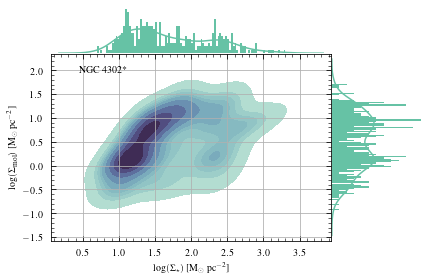

In [4]:
# Set this values
GALAXY_TO_PLOT = "NGC4302"
#
gal_inclination = INCLINATIONS[GALAXY_TO_PLOT == GALAXIES]
if gal_inclination.size != 1:
    raise ValueError(
        f"gal_inclination should only have 1 element. gal_inclination = {gal_inclination}"
    )
gal_inclination = gal_inclination[0]
#
(gal_sigstar, gal_sigstar_err, gal_sigmol, gal_sigmol_err, gal_mgms_isgood) = get_mgms_quantities(
    GALAXY_TO_PLOT, inclination=gal_inclination
)
#
# Plot
#
fig, ax, ax_r, ax_t = pu.joint_contour_plot(
    gal_sigstar[gal_mgms_isgood],
    gal_sigmol[gal_mgms_isgood],
    plot_lts=False,
    fig_xlabel=r"$\rm \log(\Sigma_\star)$ [$\rm M_\odot\; pc^{-2}$]",
    fig_ylabel=r"$\rm \log(\Sigma_{mol})$ [$\rm M_\odot\; pc^{-2}$]",
    plot_scatter=False,
    plt_show=False,
)
#
# Add galaxy name on plot
#
high_i_str = "*" if gal_inclination >= I_THRESHOLD else ""
ax.text(
    0.1,
    0.9,
    re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
    c="k",
    ha="left",
    transform=ax.transAxes,
)
# fig.savefig(MGMS_PATH + f"{GALAXY_TO_PLOT}_MGMS_LTSfail_i_corr.pdf")
plt.show()

# rMGMS for all NGVS-VERTICO galaxies

Except NGC 4302 since LTS fitting fails.

We will produce 1 pickle file per galaxy containing its rMGMS data and LTS line of best
fit.


In [4]:
# Set these 2 parameters
GAL_CLIP = 2.6  # any data outside of 2.6 sigma will be considered an outlier
LTS_PIVOT_FUNC = np.median
#
if LTS_PIVOT_FUNC == np.median:
    lts_pivot_func_str = "median"
elif LTS_PIVOT_FUNC == np.mean:
    lts_pivot_func_str = "mean"
else:
    raise ValueError(
        "LTS_PIVOT_FUNC must be np.median or np.mean (NaNs are already excluded)"
    )

def do_mgms_lts_all(gal):
    """
    Calculates MGMS quantities and LTS line of best fit, then saves results to pickle
    file. Meant to be called in parallel using multiprocessing.
    """
    (
        (gal_sigstar, gal_sigstar_err, gal_sigmol, gal_sigmol_err, gal_mgms_isgood),
        (
            gal_pivot,
            gal_slope,
            gal_slope_err,
            gal_int,
            gal_int_err,
            gal_rms,
            gal_yint,
            gal_yint_err,
        ),
    ) = do_mgms_lts(gal, clip=GAL_CLIP, pivot_func=LTS_PIVOT_FUNC, plot=False)
    # ! May want to change the path where you save the pickle file
    with open(MGMS_PATH + f"{gal}_MGMS_clip{GAL_CLIP}_noNorm.pkl", "wb") as f:
        dill.dump(
            {
                "log_M_density": gal_sigstar,
                "log_M_density_err": gal_sigstar_err,
                "log_gas_density": gal_sigmol,
                "log_gas_density_err": gal_sigmol_err,
                "mgms_isgood": gal_mgms_isgood,
                "lts_pivot": gal_pivot,
                "lts_pivot_func": lts_pivot_func_str,
                "lts_clip": GAL_CLIP,
                "lts_slope": gal_slope,
                "lts_slope_err": gal_slope_err,
                "lts_int": gal_int,
                "lts_int_err": gal_int_err,
                "lts_rms": gal_rms,
                "lts_yint": gal_yint,
                "lts_yint_err": gal_yint_err,
            },
            f,
        )
    print("Pickled", MGMS_PATH + f"{gal}_MGMS_clip{GAL_CLIP}_noNorm.pkl")


In [5]:
# Find each galaxy's rMGMS (except NGC4302, which will fail)
with Pool(processes=None) as p:
    p.map(do_mgms_lts_all, GALAXIES)
print("Done")



WARNINGWARNING

: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNINGWARNINGWARNINGWARNING
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [a

sig_int:     0.0000      3.0787
Computing sig_int
sig_int:     0.0000      2.2382
Computing sig_int
sig_int:     0.0000     10.6446
Computing sig_int
sig_int:     0.0000      4.7421
Computing sig_intsig_int:     0.0000      1.1685

Computing sig_intsig_int:     0.0000     37.6536

sig_int:     0.0000     14.0616
sig_int:     0.0000      0.4794Computing sig_intsig_int:     0.0000      0.6397
Computing sig_int
Computing sig_int

Computing sig_int

sig_int:     0.0000      0.8432sig_int:     0.0000      0.2543
Computing sig_int

sig_int:     0.0000     33.5830
Computing sig_intComputing sig_int

sig_int:     0.0000     25.2987
Computing sig_int
sig_int:     0.0000      1.4354
sig_int:     0.0000     17.2956Computing sig_int
Computing sig_int

sig_int:     0.0000      4.4944sig_int:     0.0000      9.2064sig_int:     0.0000      0.5073sig_int:     0.0000      3.4350

Computing sig_intsig_int:     0.0000     36.2413

Computing sig_intComputing sig_int



Computing sig_intComputing sig_intsi

/tmp/ipykernel_54296/3365738129.py:68: RuntimeWarning: invalid value encountered in log10
  log_gas_density = np.log10(gas_density)


sig_int:     0.3950     -0.5695sig_int:     0.1589      0.0934

sig_int:     0.3674     -0.5028
sig_int:     0.3958     -0.5547
sig_int:     0.4792     -0.3515
sig_int:     0.5196     -0.6969
sig_int:     0.3156     -0.3284sig_int:     0.3034     -0.7185
sig_int:     0.2098     -0.2963
sig_int:     0.4204     -0.4155

sig_int:     0.2882     -0.3094
sig_int:     0.4349     -0.4789
sig_int:     0.3574     -0.0015sig_int:     0.4580     -0.7217

sig_int:     0.5110     -0.6138
sig_int:     0.2189      1.0372
sig_int:     0.2467     -0.1244sig_int:     0.5618     -0.0836

sig_int:     0.1694      0.0533sig_int:     0.1529      0.0122

sig_int:     0.1975      0.4114
sig_int:     0.1785     -0.0419
sig_int:     0.3343      0.4913
sig_int:     0.2627     -0.2530
sig_int:     0.2701     -0.1467
sig_int:     0.8616     -0.7679sig_int:     0.2003     -0.0631
sig_int:     0.3739     -0.0138

sig_int:     0.0000      3.3789
sig_int:     0.5684     -0.7337
sig_int:     0.2518     -0.5479
sig_int:

sig_int:     0.3855      0.0006sig_int:     0.3919     -0.0010
sig_int:     0.4101     -0.4689
Computing sig_int error
sig_int:     0.2435     -0.2622

sig_int:     0.1563      0.0010sig_int:     0.1346      0.0006sig_int:     0.3173      0.0008


Computing sig_int error
Computing sig_int error
sig_int:     0.2216     -0.0516
sig_int:     0.2883      0.0458
sig_int:     0.2467      0.0000
sig_int:     0.4380     -0.0031sig_int:     0.1316      0.0523

sig_int:     0.1666     -0.0064
sig_int:     0.2338     -0.0262
sig_int:     0.2492     -0.0648
sig_int:     0.5294     -0.6582
sig_int:     0.2411      0.0474
sig_int:     0.2698     -0.0614sig_int:     0.5466     -0.4901
sig_int:     0.5714     -0.0304

sig_int:     0.1810      0.0004
sig_int:     0.3916      0.0000Computing sig_int error

Repeat at best fitting solution
sig_int:     0.4538     -0.5396sig_int:     0.2468     -0.0006sig_int:     0.1961     -0.0027sig_int:     0.5321     -0.5547



sig_int:     0.1653     -0.0223
Repeat a


sig_int:     0.3491     -0.0584
##########################################################sig_int:     0.2834     -0.0760sig_int:     0.3552     -0.0046

sig_int:     0.1956     -0.0000
seconds 77.90

NGC4299's LTS line: y = (0.4388966180143478 +/- 0.07449872973323132) * x + (-0.3252904572462028 +/- 0.11801740273991769)
sig_int:     0.1660     -0.0003sig_int:     0.2902     -0.0024

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/MGMS/NGC4299_MGMS_clip2.6_noNorm.pkl
sig_int:     0.2354     -0.3553
sig_int:     0.3261     -0.0011
sig_int:     0.4477     -0.4045


sig_int:     0.2560     -0.0006
Repeat at best fitting solutionsig_int:     0.1622     -0.0008

sig_int:     0.1396     -0.0005
sig_int:     0.0000      1.3797
Computing sig_int
sig_int:     0.2558     -0.0143
sig_int:     0.8882     -0.7241sig_int:     0.2609      0.1081

sig_int:     0.2532      0.0381sig_int:     0.1811      0.0709

sig_int:     0.2069     -0.0014
sig_int:     0.3541      0.0000sig_int:     0.2306     -0.0043

sig_int:     0.2106      0.0000
sig_int:     0.9825     -0.7858
sig_int:     0.2563     -0.0658
sig_int:     0.4146     -0.0001
sig_int:     0.1429     -0.0124################# Values and formal errors ################
sig_int:     0.2899     -0.0001

 intercept:  -0.387 +/- 0.028
sig_int:     0.1955      0.0006     slope:  0.741 +/- 0.046

Repeat at best fitting solution
sig_int:     0.2287      0.0000
   scatter:  0.415 +/- 0.023sig_int:     0.5615      0.0000
################# Values and formal errors ################

 intercept:  0.684 +/- 0.029
     slop

ValueError: f(a) and f(b) must have different signs

## Auto-generate rMGMS plots from pickle files


In [6]:
GAL_CLIP = 2.6
I_THRESHOLD = 80  # threshold for what is considered a high-inclination galaxy

for gal, gal_i in zip(GALAXIES, INCLINATIONS):
    if gal == "NGC4302":
        continue  # failed LTS fitting. No pickle file
    print("Plotting", gal)
    with open(MGMS_PATH + f"{gal}_MGMS_clip{GAL_CLIP}_noNorm.pkl", "rb") as f:
        file = dill.load(f)
        gal_sigstar = file["log_M_density"]
        gal_sigstar_err = file["log_M_density_err"]
        gal_sigmol = file["log_gas_density"]
        gal_sigmol_err = file["log_gas_density_err"]
        gal_mgms_isgood = file["mgms_isgood"]
        gal_slope = file["lts_slope"]
        gal_int = file["lts_int"]
        gal_pivot = file["lts_pivot"]
        gal_rms = file["lts_rms"]
        gal_clip = file["lts_clip"]
        file = None  # free memory
    fig, ax, ax_r, ax_t = pu.joint_contour_plot(
        gal_sigstar[gal_mgms_isgood],
        gal_sigmol[gal_mgms_isgood],
        plot_lts=True,
        lts_slope=gal_slope,
        lts_int=gal_int,
        lts_pivot=gal_pivot,
        lts_rms=gal_rms,
        lts_clip=gal_clip,
        fig_xlabel=r"$\rm \log(\Sigma_\star)$ [$\rm M_\odot\; pc^{-2}$]",
        fig_ylabel=r"$\rm \log(\Sigma_{mol})$ [$\rm M_\odot\; pc^{-2}$]",
        plot_scatter=False,
        plt_show=False,
    )
    #
    # Add galaxy name on plot
    #
    high_i_str = "*" if gal_i >= I_THRESHOLD else ""
    ax.text(
        0.1,
        0.9,
        re.sub(r"(\d+)", " \\1", gal) + high_i_str,
        c="k",
        ha="left",
        transform=ax.transAxes,
    )
    fig.savefig(MGMS_PATH + f"{gal}_MGMS_clip{gal_clip}_autoGenerated_noNorm_i_corr.pdf")
    plt.close()

Plotting IC3392
Plotting NGC4192
Plotting NGC4216
Plotting NGC4222
Plotting NGC4254
Plotting NGC4294
Plotting NGC4298
Plotting NGC4299
Plotting NGC4321
Plotting NGC4330
Plotting NGC4351
Plotting NGC4380
Plotting NGC4383
Plotting NGC4388
Plotting NGC4396
Plotting NGC4402
Plotting NGC4405
Plotting NGC4419
Plotting NGC4424
Plotting NGC4450
Plotting NGC4501
Plotting NGC4522
Plotting NGC4532
Plotting NGC4535
Plotting NGC4548
Plotting NGC4567
Plotting NGC4568
Plotting NGC4569
Plotting NGC4579
Plotting NGC4580
Plotting NGC4607
Plotting NGC4651
Plotting NGC4654
Plotting NGC4689
Plotting NGC4694


# Global Unresolved MGMS for NGVS-VERTICO


Function below calculates the quantities necessary for the global, unresolved MGMS (i.e.,
log10(total gas mass) vs. log10(total stellar mass)).


In [3]:
ALPHA_CO = 4.35  # M_sun/pc^2 per (K km/s)
R_21 = 0.8  # dimensionless. CO(2-1)/CO(1-0) ratio
I_THRESHOLD = 80  # degrees


def get_unresolved_mgms_quantities(
    galaxy, dist=16.5 * u.Mpc, dist_err=0 * u.Mpc, alpha_co=ALPHA_CO, r_21=R_21, inclination=None, i_threshold=I_THRESHOLD
):
    """
    Calculates log10(total gas mass) and log10(total stellar mass) + associated errors.
    """
    #
    # Load stellar mass density data
    #
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
    galaxy_infile = (
        galpath + f"{galaxy}_regBin_extinctionCorr_nyquist_ugiz_Sigma-star_noNorm_i_corr.pkl"
    )
    with open(galaxy_infile, "rb") as f:
        file = dill.load(f)
        M_density = file["stellar_mass_density"]
        M_density_err = file["stellar_mass_density_err"]
        file = None  # free memory
    #
    # Load molecular gas data
    #
    if (
        galaxy == "NGC4321"
    ):  # no 9 arcsec data since native is 10 arcsec. Use 15 arcsec data instead
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/nyquistPix/15arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_15as_np_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/nyquistPix/15arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_15as_np_round_mom0_unc.fits"
    else:
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_np_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"
    Ico_data, gal_header = fits.getdata(Ico_path, header=True)
    Ico_unc = fits.getdata(Ico_unc_path)  # uncertainty
    gal_wcs = WCS(gal_header)
    #
    # Convert to gas density (M_sun/pc^2)
    #
    gas_density_i_uncorr = alpha_co / r_21 * Ico_data
    gas_density_unc_i_uncorr = alpha_co / r_21 * Ico_unc
    #
    # Correct for inclination
    #
    if inclination is None:
        inclination = INCLINATIONS[galaxy == GALAXIES]
        if inclination.size != 1:
            raise ValueError(
                f"{galaxy}'s inclination should only have 1 element. inclination = {gal_inclination}"
            )
        inclination = inclination[0]
    gas_density = rpu.correct_for_i(
        gas_density_i_uncorr,
        inclination,
        i_threshold=i_threshold,
        i_replacement=i_threshold,
    )
    gas_density_unc = rpu.correct_for_i(
        gas_density_unc_i_uncorr,
        inclination,
        i_threshold=i_threshold,
        i_replacement=i_threshold,
    )
    #
    # Mask to remove bad pixels (to ensure same points are used in rMGMS and global, unresolved MGMS sum)
    #
    mgms_isgood = (
        np.isfinite(np.log10(M_density))
        & np.isfinite(M_density_err / (np.log(10) * M_density))
        & np.isfinite(np.log10(gas_density))
        & np.isfinite(gas_density_unc / (np.log(10) * gas_density))
    )
    #
    # Convert densities to masses
    #
    # Get physical area of pixels in square parsecs
    px_dimensions, px_dimensions_err = fu.calc_pc_per_px(gal_wcs, dist, dist_err=dist_err)  # parsecs
    px_area = px_dimensions[0] * px_dimensions[1]  # square parsecs
    px_area_err = px_area * np.sqrt(np.sum((px_dimensions_err / px_dimensions) ** 2))
    # Convert stellar mass densities to stellar massses
    # (i.e., reverse of procedure in
    # `coop_f2021/galaxies/stellar_mass_densities/stellar_mass_densities+vorbin_radial_profiles.ipynb`)
    M = M_density * px_area
    M_err = M * np.sqrt((M_density_err / M_density) ** 2 - (px_area_err / px_area) ** 2)
    # Convert molecular gas densities to molecular gas masses
    gas = gas_density * px_area
    gas_err = gas * np.sqrt((gas_density_unc / gas_density) ** 2 - (px_area_err / px_area) ** 2)
    # Get area of galaxy
    gal_area = px_area * np.sum(mgms_isgood)
    gal_area_err = px_area_err * np.sum(mgms_isgood)
    #
    # Calculate log10 total M_star and M_mol
    #
    tot_M = np.sum(M[mgms_isgood])
    tot_M_err = np.sqrt(np.sum(M_err[mgms_isgood] ** 2))
    log_tot_M = np.log10(tot_M)
    log_tot_M_err = tot_M_err / (np.log(10) * tot_M)
    tot_gas = np.sum(gas[mgms_isgood])
    tot_gas_err = np.sqrt(np.sum(gas_err[mgms_isgood] ** 2))
    log_tot_gas = np.log10(tot_gas)
    log_tot_gas_err = tot_gas_err / (np.log(10) * tot_gas)
    #
    # Calculate log10 total Sigma_star and Sigma_mol
    #
    tot_M_density = tot_M / gal_area
    tot_M_density_err = tot_M_density * np.sqrt((tot_M_err / tot_M) ** 2 + (gal_area_err / gal_area) ** 2)
    log_tot_M_density = np.log10(tot_M_density)
    log_tot_M_density_err = tot_M_density_err / (np.log(10) * tot_M_density)
    #
    tot_gas_density = np.sum(gas[mgms_isgood]) / gal_area
    tot_gas_density_err = tot_gas_density * np.sqrt((tot_gas_err / tot_gas) ** 2 + (gal_area_err / gal_area) ** 2)
    log_tot_gas_density = np.log10(tot_gas_density)
    log_tot_gas_density_err = tot_gas_density_err / (np.log(10) * tot_gas_density)
    #
    return (
        log_tot_M,
        log_tot_M_err,
        log_tot_gas,
        log_tot_gas_err,
        gal_area,
        gal_area_err,
        log_tot_M_density,
        log_tot_M_density_err,
        log_tot_gas_density,
        log_tot_gas_density_err,
    )

Use multiprocessing to run function above in parallel.

In [4]:
with Pool(processes=None) as p:
    (
        global_log_tot_M,
        global_log_tot_M_err,
        global_log_tot_gas,
        global_log_tot_gas_err,
        global_area,
        global_area_err,
        global_log_tot_M_density,
        global_log_tot_M_density_err,
        global_log_tot_gas_density,
        global_log_tot_gas_density_err,
    ) = zip(*p.map(get_unresolved_mgms_quantities, GALAXIES))
global_log_tot_M = list(global_log_tot_M)
global_log_tot_M_err = list(global_log_tot_M_err)
global_log_tot_gas = list(global_log_tot_gas)
global_log_tot_gas_err = list(global_log_tot_gas_err)
global_area = list(global_area)
global_area_err = list(global_area_err)
global_log_tot_M_density = list(global_log_tot_M_density)
global_log_tot_M_density_err = list(global_log_tot_M_density_err)
global_log_tot_gas_density = list(global_log_tot_gas_density)
global_log_tot_gas_density_err = list(global_log_tot_gas_density_err)
print("Done")


: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]


: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58839.379235 from DATE-OBS'. [astropy.wcs.wcs]: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58125.369839 from DATE-OBS'. [astropy.wcs.wcs]

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]WARNING: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]
: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]WARNING

/tmp/ipykernel_69/3385749575.py:68: RuntimeWarning: divide by zero encountered in log10
  & np.isfinite(n

Done


Save all global unresolved MGMS data in 1 pickle file


In [5]:
global_MGMS_outfile = MGMS_PATH + "NGVS-VERTICO_global_MGMS.pkl"
with open(global_MGMS_outfile, "wb") as f:
    dill.dump(
        {
            "galaxies": GALAXIES,
            "log_tot_M": global_log_tot_M,
            "log_tot_M_err": global_log_tot_M_err,
            "log_tot_gas": global_log_tot_gas,
            "log_tot_gas_err": global_log_tot_gas_err,
            "gal_area": global_area,
            "gal_area_err": global_area_err,
            "log_tot_M_density": global_log_tot_M_density,
            "log_tot_M_density_err": global_log_tot_M_density_err,
            "log_tot_gas_density": global_log_tot_gas_density,
            "log_tot_gas_density_err": global_log_tot_gas_density_err,
        },
        f,
    )
print("Pickled", global_MGMS_outfile)

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/MGMS/NGVS-VERTICO_global_MGMS.pkl


## Plot global unresolved MGMS

Points are colour-coded by their rMGMS slopes.

Must have pickle files containing individual rMGMSs and the pickle file for the global
MGMS. That is, run the cells above before running the cells below.


In [3]:
# 
# Load data
# 
global_MGMS_infile = MGMS_PATH + "NGVS-VERTICO_global_MGMS.pkl"
with open(global_MGMS_infile, "rb") as f:
    file = dill.load(f)
    galaxies = file["galaxies"]
    log_tot_M = file["log_tot_M"]
    log_tot_M_err = file["log_tot_M_err"]
    log_tot_gas = file["log_tot_gas"]
    log_tot_gas_err = file["log_tot_gas_err"]
    gal_area = file["gal_area"]
    gal_area_err = file["gal_area_err"]
    log_tot_M_density = file["log_tot_M_density"]
    log_tot_M_density_err = file["log_tot_M_density_err"]
    log_tot_gas_density = file["log_tot_gas_density"]
    log_tot_gas_density_err = file["log_tot_gas_density_err"]
    file = None  # free memory
# 
GAL_CLIP = 2.6  # specifies the pickle file to use
lts_slopes = []
for gal in galaxies:
    if gal == "NGC4302":
        continue  # failed LTS fitting. No pickle file
    with open(MGMS_PATH + f"{gal}_MGMS_clip{GAL_CLIP}_noNorm.pkl", "rb") as f:
        lts_slopes.append(dill.load(f)["lts_slope"])
# 
# Remove NGC 4302 from all lists since no LTS slope
# 
ngc4302_idx = np.where(galaxies == "NGC4302")[0][0]
galaxies = np.delete(galaxies, ngc4302_idx)
log_tot_M.pop(ngc4302_idx)
log_tot_M_err.pop(ngc4302_idx)
log_tot_gas.pop(ngc4302_idx)
log_tot_gas_err.pop(ngc4302_idx)
gal_area.pop(ngc4302_idx)
gal_area_err.pop(ngc4302_idx)
log_tot_M_density.pop(ngc4302_idx)
log_tot_M_density_err.pop(ngc4302_idx)
log_tot_gas_density.pop(ngc4302_idx)
log_tot_gas_density_err.pop(ngc4302_idx)

0.000497281836444672

sig_int:     0.0000     68.3053
Computing sig_int
sig_int:     0.0000     68.3053
sig_int:     0.0960     -0.5576
sig_int:     0.0952     -0.5505
sig_int:     0.0476      0.7371
sig_int:     0.0749     -0.2781
sig_int:     0.0598      0.1203
sig_int:     0.0643     -0.0289
sig_int:     0.0634     -0.0024
sig_int:     0.0634      0.0000
sig_int:     0.0634     -0.0010
Computing sig_int error
sig_int:     0.0634      0.3430
sig_int:     0.0960     -0.2146
sig_int:     0.0834     -0.0737
sig_int:     0.0780      0.0084
sig_int:     0.0786     -0.0008
sig_int:     0.0785     -0.0000
sig_int:     0.0785      0.0006
Repeat at best fitting solution
sig_int:     0.0634      0.0000
################# Values and formal errors ################
 intercept:  8.764 +/- 0.018
     slope:  1.229 +/- 0.026
   scatter:  0.063 +/- 0.015
Observed rms scatter: 0.064
y = a + b*(x - pivot) with pivot = 9.826
Spearman r=0.89 and p=1.6e-12
Pearson r=0.89 and p=8.4e-13
###########################################

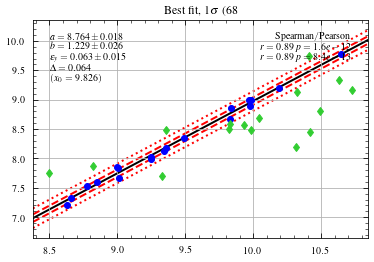

In [9]:
# 
# Get LTS line of best fit
# 
sample_pivot = np.median(log_tot_M)
sample_lts_clip = 2.6
# 
sample_lts_popt = lts_linefit(
    np.array(log_tot_M),
    np.array(log_tot_gas),
    np.array(log_tot_M_err),
    np.array(log_tot_gas_err),
    clip=sample_lts_clip,
    epsy=True,
    corr=True,
    frac=None,
    pivot=sample_pivot,
    plot=True,
    text=True,
)

sample_lts_int, sample_lts_slope = sample_lts_popt.ab
sample_lts_int_err, sample_lts_slope_err = sample_lts_popt.ab_err
sample_lts_rms = sample_lts_popt.rms
sample_lts_yint = sample_lts_int - sample_lts_slope * sample_pivot
sample_lts_yint_err = np.sqrt(sample_lts_int_err ** 2 + (sample_lts_slope_err * sample_pivot) ** 2)

print(f"NGVS-VERTICO LTS line: y = ({sample_lts_slope} +/- {sample_lts_slope_err}) * x + ({sample_lts_yint} +/- {sample_lts_yint_err})")

/tmp/ipykernel_1116/1750810648.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(img)


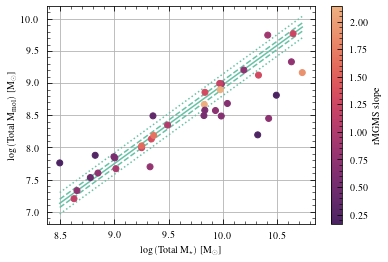

In [10]:
# 
# Plot global, unresolved MGMS for NGVS-VERTICO sample (excl. NGC 4302)
# 
fig, ax = plt.subplots()
img = ax.scatter(log_tot_M, log_tot_gas, c=lts_slopes, cmap=sns.color_palette("flare_r", as_cmap=True), zorder=10)
cbar = fig.colorbar(img)
cbar.set_label("rMGMS slope")
ax.errorbar(  # error bars are too small to be seen
    x=log_tot_M,
    y=log_tot_gas,
    xerr=log_tot_M_err,
    yerr=log_tot_gas_err,
    fmt="none",
    ecolor="r"
)
pu.add_lts_line(
    ax,
    sample_lts_slope,
    sample_lts_int,
    sample_pivot,
    lts_rms=sample_lts_rms,
    lts_clip=sample_lts_clip,
    lts_xlim=None,
    xdata=log_tot_M,
    lts_color="C0",
)
# ax.set_aspect("equal")
ax.set_xlabel(r"$\rm \log\left(Total\ M_\star\right)$ [$\rm M_\odot$]")
ax.set_ylabel(r"$\rm \log\left(Total\ M_{mol}\right)$ [$\rm M_\odot$]")
# fig.savefig("NGVS-VERTICO_MGMS_total_masses_no4302_noNorm_i_corr.pdf")
plt.show()